## Transfer Learning
For many applied problems, there are no large labeled datasets.
A common trick is training on a similar but large dataset and completing updating the weights using the small target dataset.

This technique is called ** Transfer Learning **

In convolution networks  for classification, there are two parts:
- the body of the network is a set of convolutions and poolings
- the head is MLP (a set of fully connected layers) after which softmax is applied and the probabilities of different classes are obtained.


A computationally simple tranfer learning option is to retrain the head network.


We need a [pre-trained model] (http://pytorch.org/docs/master/torchvision/datasets.html#torchvision-datasets) and a dataset for our task.

We will transfer ImageNet to the dataset https://download.pytorch.org/tutorial/hymenoptera_data.zip


The dataset contains pictures of two classes (`ants` and` bees`) of different sizes.

The data loader is one of the important components for the effective training of neural networks:
Asynchronous loading and fast preprocessing are important for full GPU utilization.

We recommend that you familiarize yourself with and use [Pytorch Dataset] (http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class)

Usage example:

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os


data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'F:/study/masters/3 sem/OR-610/Assignment-3/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()
plt.ion()

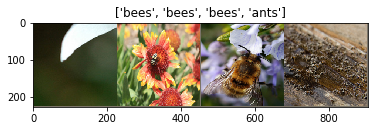

In [2]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.1)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [3]:
# we save the best weights thus far
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels).type(torch.float)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
        
        time_elapsed = time.time() - since
        print('Elapsed {:.0f}m {:.0f}s\n'.format(time_elapsed // 60, time_elapsed % 60))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [4]:
# torchvision has many models with pre-trained weigts:
[m for m in dir(models) if not m.startswith('_')]

['AlexNet',
 'DenseNet',
 'GoogLeNet',
 'Inception3',
 'MNASNet',
 'MobileNetV2',
 'ResNet',
 'ShuffleNetV2',
 'SqueezeNet',
 'VGG',
 'alexnet',
 'densenet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'detection',
 'googlenet',
 'inception',
 'inception_v3',
 'mnasnet',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet',
 'mobilenet_v2',
 'resnet',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext50_32x4d',
 'segmentation',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'shufflenet_v2_x1_5',
 'shufflenet_v2_x2_0',
 'shufflenetv2',
 'squeezenet',
 'squeezenet1_0',
 'squeezenet1_1',
 'utils',
 'vgg',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vgg16_bn',
 'vgg19',
 'vgg19_bn',
 'video',
 'wide_resnet101_2',
 'wide_resnet50_2']

In [128]:
model_ft = models.resnet18(pretrained=True)
# hint: dir() returns list of members (variables, functions) defined in a class

# List of layers can be printed using
for x in model_ft.named_modules():
    print(x[0], x[1])

 ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

)
layer2.0 BasicBlock(
  (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (downsample): Sequential(
    (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
layer2.0.conv1 Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
layer2.0.bn1 BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
layer2.0.relu ReLU(inplace=True)
layer2.0.conv2 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer2.0.bn2 BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_r

)
layer4.1.conv1 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer4.1.bn1 BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
layer4.1.relu ReLU(inplace=True)
layer4.1.conv2 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer4.1.bn2 BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
avgpool AdaptiveAvgPool2d(output_size=(1, 1))
fc Linear(in_features=512, out_features=1000, bias=True)


In [129]:
model_ft.fc

Linear(in_features=512, out_features=1000, bias=True)

In [7]:
# TODO: Change the last layer that does binary classification

#<your code>
model_ft.fc = nn.Linear(512,2)
# TODO: pick parameters to be re-trainrd. When you get better prediction, whenyou retrain the whole model or just the last layer?
# Why?
# for example, you can turn-off lernaing for all of the parameters using
for params in model_ft.parameters():
    params.requires_grad = False 

#turn-on learning only for last layer    
for params in model_ft.fc.parameters():
    params.requires_grad = True

In [8]:
params_to_train = model_ft.fc.parameters()

# use GPU if you have it
if use_gpu:
    model_ft = model_ft.cuda()

# loss
criterion = nn.CrossEntropyLoss()

# Create optimizer on the selected parameters
optimizer_ft = optim.SGD(params_to_train, lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

<b>RE-TRAINING only the Last Layer</b>

In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)
# if you did everything correctly, the accuracy should be more than94%

Epoch 0/24
----------


C:\Users\Chava Sujan\Anaconda2\lib\site-packages\torch\optim\lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.1503 Acc: 0.6270
val Loss: 0.0932 Acc: 0.8366
Elapsed 1m 4s

Epoch 1/24
----------
train Loss: 0.1105 Acc: 0.8115
val Loss: 0.0574 Acc: 0.9150
Elapsed 2m 6s

Epoch 2/24
----------
train Loss: 0.1256 Acc: 0.8074
val Loss: 0.1498 Acc: 0.7647
Elapsed 3m 8s

Epoch 3/24
----------
train Loss: 0.1131 Acc: 0.8074
val Loss: 0.0465 Acc: 0.9281
Elapsed 4m 10s

Epoch 4/24
----------
train Loss: 0.1010 Acc: 0.8320
val Loss: 0.0612 Acc: 0.9150
Elapsed 5m 12s

Epoch 5/24
----------
train Loss: 0.1470 Acc: 0.7787
val Loss: 0.0786 Acc: 0.8954
Elapsed 6m 13s

Epoch 6/24
----------
train Loss: 0.0889 Acc: 0.8648
val Loss: 0.0778 Acc: 0.9085
Elapsed 7m 15s

Epoch 7/24
----------
train Loss: 0.0850 Acc: 0.8689
val Loss: 0.0444 Acc: 0.9477
Elapsed 8m 17s

Epoch 8/24
----------
train Loss: 0.0935 Acc: 0.8320
val Loss: 0.0448 Acc: 0.9477
Elapsed 9m 18s

Epoch 9/24
----------
train Loss: 0.0792 Acc: 0.8648
val Loss: 0.0449 Acc: 0.9412
Elapsed 10m 19s

Epoch 10/24
----------
train Loss: 0.0842 Ac

<b>RE-TRAINING the Whole Model</b>

In [10]:
#turn-on learning for parameters of all the layers
for params in model_ft.parameters():
    params.requires_grad = True

In [12]:
params_to_train = model_ft.parameters()

# use GPU if you have it
if use_gpu:
    model_ft = model_ft.cuda()

# loss
criterion = nn.CrossEntropyLoss()

# Create optimizer on the selected parameters
optimizer_ft = optim.SGD(params_to_train, lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.1132 Acc: 0.8115
val Loss: 0.0630 Acc: 0.9346
Elapsed 1m 60s

Epoch 1/24
----------
train Loss: 0.1125 Acc: 0.8156
val Loss: 0.0866 Acc: 0.8889
Elapsed 3m 60s

Epoch 2/24
----------
train Loss: 0.1334 Acc: 0.7910
val Loss: 0.0750 Acc: 0.9346
Elapsed 6m 2s

Epoch 3/24
----------
train Loss: 0.1272 Acc: 0.7951
val Loss: 0.1201 Acc: 0.8758
Elapsed 8m 5s

Epoch 4/24
----------
train Loss: 0.0894 Acc: 0.8730
val Loss: 0.1025 Acc: 0.8758
Elapsed 10m 37s

Epoch 5/24
----------
train Loss: 0.1442 Acc: 0.8033
val Loss: 0.0505 Acc: 0.9477
Elapsed 12m 57s

Epoch 6/24
----------
train Loss: 0.0903 Acc: 0.8770
val Loss: 0.0478 Acc: 0.9477
Elapsed 15m 21s

Epoch 7/24
----------
train Loss: 0.0829 Acc: 0.8484
val Loss: 0.0479 Acc: 0.9542
Elapsed 17m 46s

Epoch 8/24
----------
train Loss: 0.0765 Acc: 0.8730
val Loss: 0.0472 Acc: 0.9477
Elapsed 20m 13s

Epoch 9/24
----------
train Loss: 0.0616 Acc: 0.9098
val Loss: 0.0473 Acc: 0.9477
Elapsed 22m 23s

Epoch 10/24
----

The Accuracy when we re-train only last layer is 95.42
The Accuracy when we re-train whole model is 96.07 
The best accuracy is given by the model when we re-train the whole model, because when we re-train only last layer the weights of only last layer are adjusted to give accurate prediction on validation set. Whereas in case of re-training the whole model, all the weights are updated or learned according to dataset for better prediction.  

In [ ]:
# TODO: write a fucntion that applies the model to several examples from the validation set
# Show the images and your predictions 

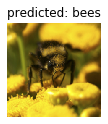

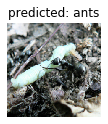

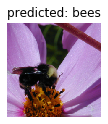

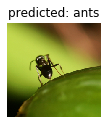

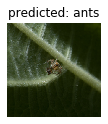

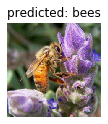

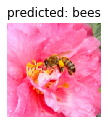

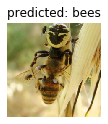

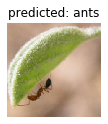

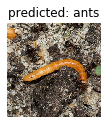

In [78]:
def visualize(model,num_images=10):
    was_training = model.training
    model.eval()
    images = 0
    
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            outputs = model(inputs)
            _, pred = torch.max(outputs,1)
            for j in range(inputs.size()[0]):
                images += 1
                fig = plt.figure(figsize=(10,10))
                ax = plt.subplot(num_images//2,2,images)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[pred[j]]))
                imshow(inputs.cpu().data[j])
                
                if images == num_images:
                    model.train(mode=was_training)
                    return
        
visualize(model_ft)